# **hajj_umrah_crowd_management_dataset**
Data diperoleh dari Kaggle

#**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Mengatur style visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# **Data Overview**

## ***1.1 Latar Belakang & Tujuan Proyek***

Penyelenggaraan Ibadah Haji dan Umrah merupakan salah satu pertemuan massa terbesar di dunia. Menjamin kepuasan dan keselamatan jutaan jamaah adalah prioritas utama. Ketidakpuasan, yang seringkali dipicu oleh kepadatan berlebih, waktu tunggu yang lama, atau insiden darurat, dapat berdampak signifikan terhadap pengalaman spiritual jamaah.

Tujuan Proyek ini adalah untuk:

1. Menganalisis faktor-faktor utama yang paling memengaruhi tingkat kepuasan jamaah.

2. Membangun model machine learning prediktif untuk mengklasifikasikan apakah seorang jamaah akan merasa "Puas" atau "Tidak Puas" berdasarkan kondisi operasional.

3. Memberikan rekomendasi yang dapat ditindaklanjuti (actionable) bagi penyelenggara untuk meningkatkan layanan dan manajemen kerumunan.

## 1.2 Gambaran Umum Dataset (Dataset Overview)

In [2]:
nama_file = 'hajj_umrah_crowd_management_dataset.csv'

try:
    # Membaca file CSV ke dalam DataFrame pandas
    df = pd.read_csv(nama_file)

    # Menampilkan 5 baris pertama dari dataset
    print("=== 5 Baris Pertama Dataset ===\n")
    print(df.head(5))

    print("\n" + "="*50 + "\n")

    # Menampilkan informasi ringkas (nama kolom, jumlah non-null, tipe data)
    print("=== Informasi Dataset ===\n")
    df.info()

except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")

=== 5 Baris Pertama Dataset ===

             Timestamp  Location_Lat  Location_Long Crowd_Density  \
0  2024-02-28 05:36:50     21.258846      39.983949          High   
1  2024-07-15 04:07:23     21.353403      39.850382           Low   
2  2024-06-06 08:27:11     21.252375      39.937753        Medium   
3  2024-12-23 06:29:22     21.377740      39.813333        Medium   
4  2024-08-19 18:00:22     21.360457      39.950974          High   

   Movement_Speed Activity_Type Weather_Conditions  Temperature  \
0            0.90         Tawaf              Clear           44   
1            0.55       Resting              Clear           39   
2            0.94        Prayer              Clear           32   
3            0.55        Prayer              Clear           41   
4            0.36          Sa’i              Rainy           44   

   Sound_Level_dB AR_System_Interaction  ...    Incident_Type Crowd_Morale  \
0              82               Started  ...            Theft      Neut

Insight:

Struktur Data: Kita memiliki 10.000 baris data dan 30 kolom (fitur).

Kualitas Data: Tidak ada nilai yang hilang (missing values) sama sekali (semua kolom Non-Null Count = 10000). Ini sangat menyederhanakan langkah pembersihan data.

Tipe Data: Data kita terdiri dari campuran:

Numerik (int64, float64): Movement_Speed, Temperature, Queue_Time_minutes, dll. (Total 13)

Kategorikal (object): Crowd_Density, Activity_Type, Fatigue_Level, dll. (Total 17)


Variabel Target: Kolom Satisfaction_Rating (tipe int64) adalah target utama kita.

<hr>

# **EDA**

Memahami pola dan menemukan insight awal sebelum membangun model.

## ***2.1 Analisis Variabel Target (Satisfaction_Rating)***

=== Statistik Deskriptif Satisfaction_Rating ===

count    10000.000000
mean         3.010100
std          1.425623
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Satisfaction_Rating, dtype: float64


=== Distribusi Frekuensi Satisfaction_Rating ===

Satisfaction_Rating
1    2041
2    1931
3    1971
4    2000
5    2057
Name: count, dtype: int64




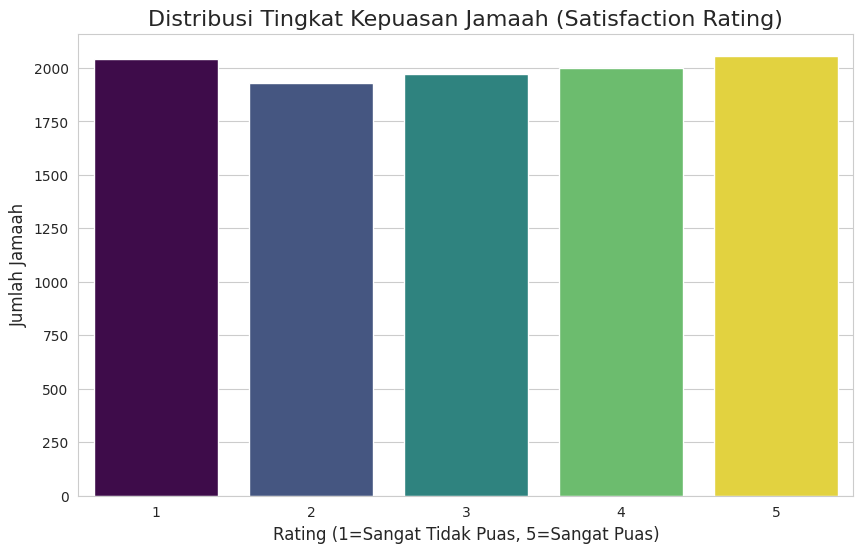

In [3]:
# 1. Mendapatkan statistik deskriptif
satisfaction_stats = df['Satisfaction_Rating'].describe()
print("=== Statistik Deskriptif Satisfaction_Rating ===\n")
print(satisfaction_stats)
print("\n" + "="*50 + "\n")

# 2. Melihat distribusi frekuensi dari setiap rating
satisfaction_counts = df['Satisfaction_Rating'].value_counts().sort_index()
print("=== Distribusi Frekuensi Satisfaction_Rating ===\n")
print(satisfaction_counts)
print("\n" + "="*50 + "\n")

# 3. Membuat visualisasi distribusi rating
plt.figure(figsize=(10, 6))
# Menggunakan 'palette' yang direkomendasikan untuk countplot
sns.countplot(x='Satisfaction_Rating', data=df, palette='viridis', hue='Satisfaction_Rating', legend=False)
plt.title('Distribusi Tingkat Kepuasan Jamaah (Satisfaction Rating)', fontsize=16)
plt.xlabel('Rating (1=Sangat Tidak Puas, 5=Sangat Puas)', fontsize=12)
plt.ylabel('Jumlah Jamaah', fontsize=12)
plt.show()

Insight:

Distribusi Seimbang: Distribusi rating sangat seimbang, dengan ~2000 sampel untuk setiap skor (1, 2, 3, 4, 5). Ini adalah skenario yang ideal untuk dataset latihan, meskipun jarang terjadi di dunia nyata.

Rata-rata Netral: Nilai rata-rata (mean) adalah 3.01, yang menunjukkan bahwa data secara keseluruhan sangat netral, tidak condong ke puas atau tidak puas.

Tujuan Klasifikasi: Karena distribusinya seimbang, kita memiliki data yang baik untuk melatih model klasifikasi.

## *2.2 Statistika Deskriptif (Fitur Numerik)*

In [4]:
# Menghasilkan statistik deskriptif untuk kolom numerik
descriptive_stats = df.describe()

# Menampilkan hasilnya
print("=== Statistika Deskriptif untuk Fitur Numerik ===\n")
pd.set_option('display.max_columns', None) # Untuk memastikan semua kolom ditampilkan
print(descriptive_stats)

=== Statistika Deskriptif untuk Fitur Numerik ===

       Location_Lat  Location_Long  Movement_Speed   Temperature  \
count  10000.000000   10000.000000    10000.000000  10000.000000   
mean      21.299628      39.898729        0.845493     37.515400   
std        0.057664       0.057236        0.377836      4.610736   
min       21.200078      39.800043        0.200000     30.000000   
25%       21.249454      39.849039        0.520000     33.000000   
50%       21.299998      39.899346        0.840000     38.000000   
75%       21.349764      39.947166        1.170000     42.000000   
max       21.399917      39.999994        1.500000     45.000000   

       Sound_Level_dB  Queue_Time_minutes  Waiting_Time_for_Transport  \
count    10000.000000        10000.000000                10000.000000   
mean        74.914200           30.256500                   59.661500   
std          9.007439           17.681492                   35.093146   
min         60.000000            0.000000   

Insight:

Waktu Tunggu: Queue_Time_minutes (rata-rata 30 mnt), Waiting_Time_for_Transport (rata-rata 60 mnt), dan Security_Checkpoint_Wait_Time (rata-rata 18 mnt) tampaknya menjadi faktor penting dalam pengalaman jamaah.

Kondisi Fisik: Temperature (rata-rata 37.5°C) dan Sound_Level_dB (rata-rata 75 dB) menunjukkan kondisi lingkungan yang cukup ekstrem.

Pergerakan: Movement_Speed (rata-rata 0.85) dan Distance_Between_People_m (rata-rata 1.5 m) adalah proksi yang baik untuk kepadatan kerumunan.

## 2.3 Analisis Univariate (Fitur Kategorikal)

=== Distribusi Fitur Kategorikal ===



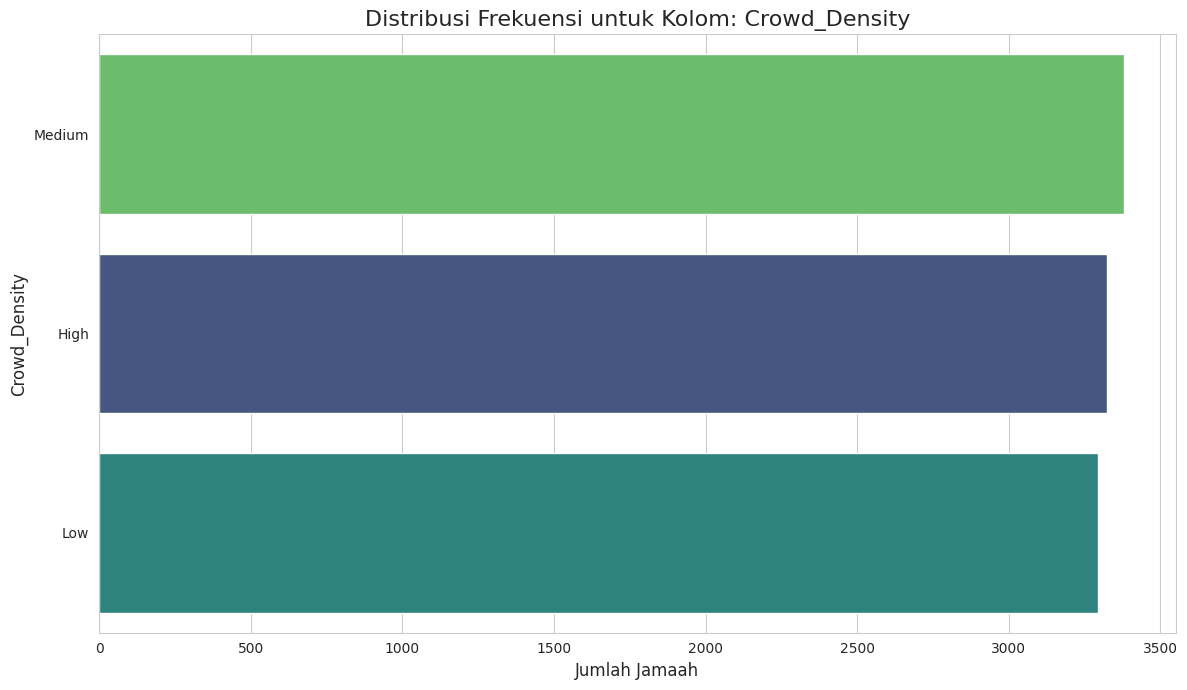

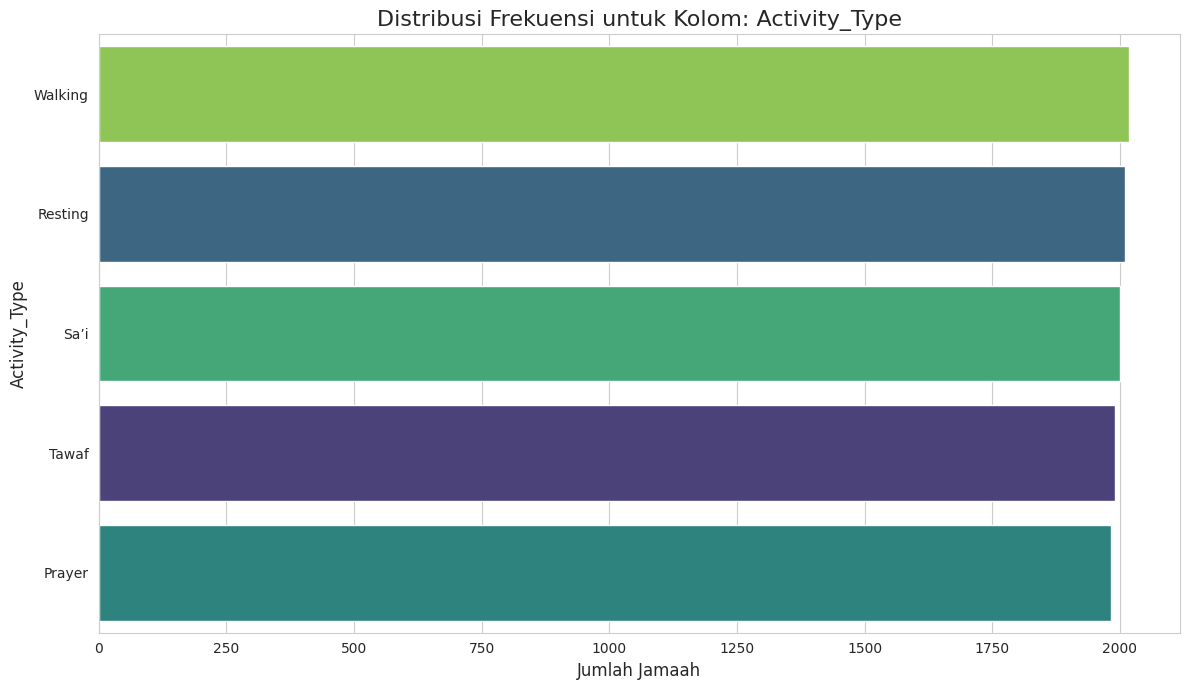

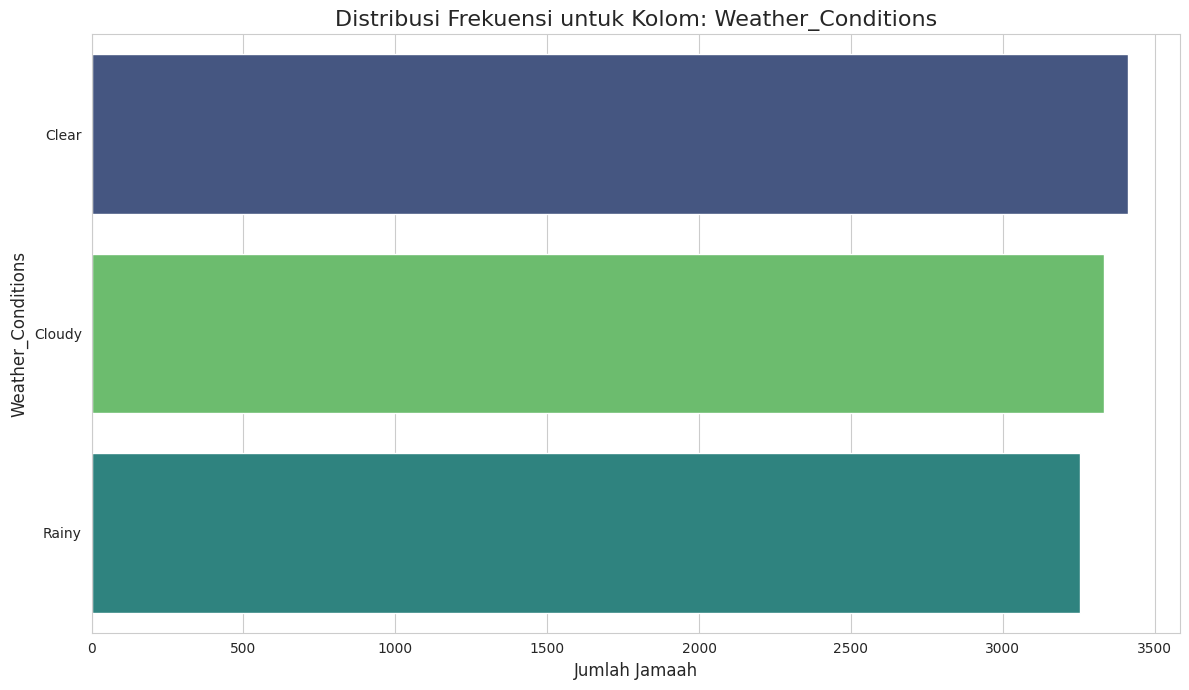

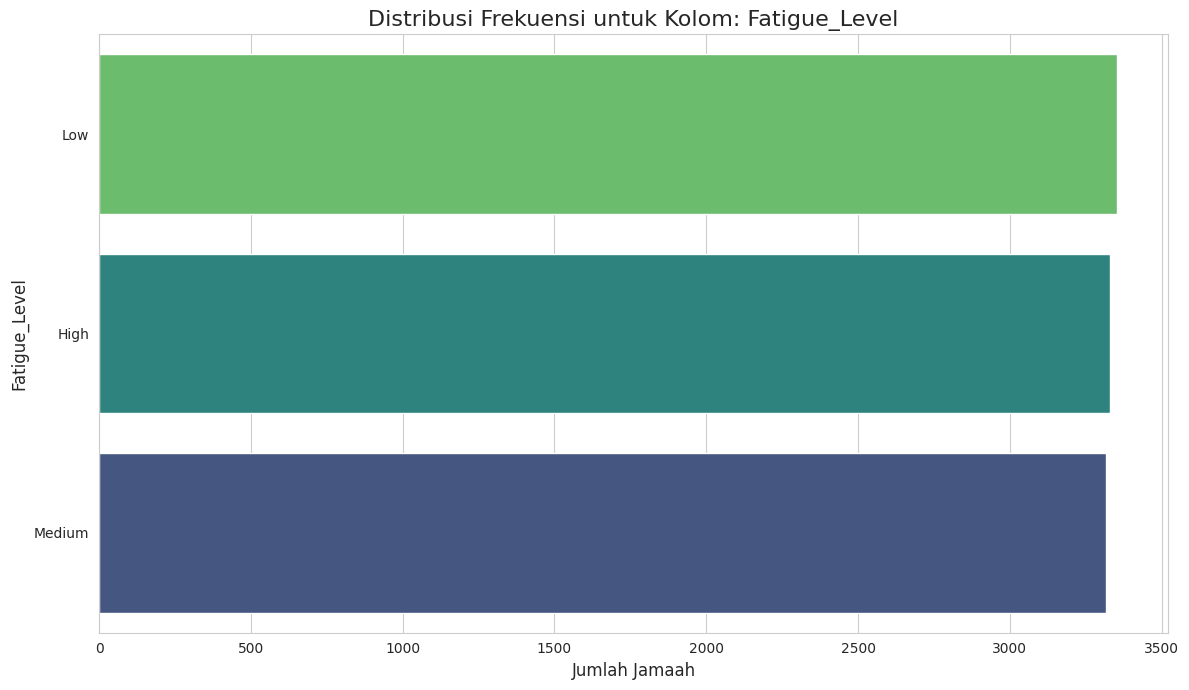

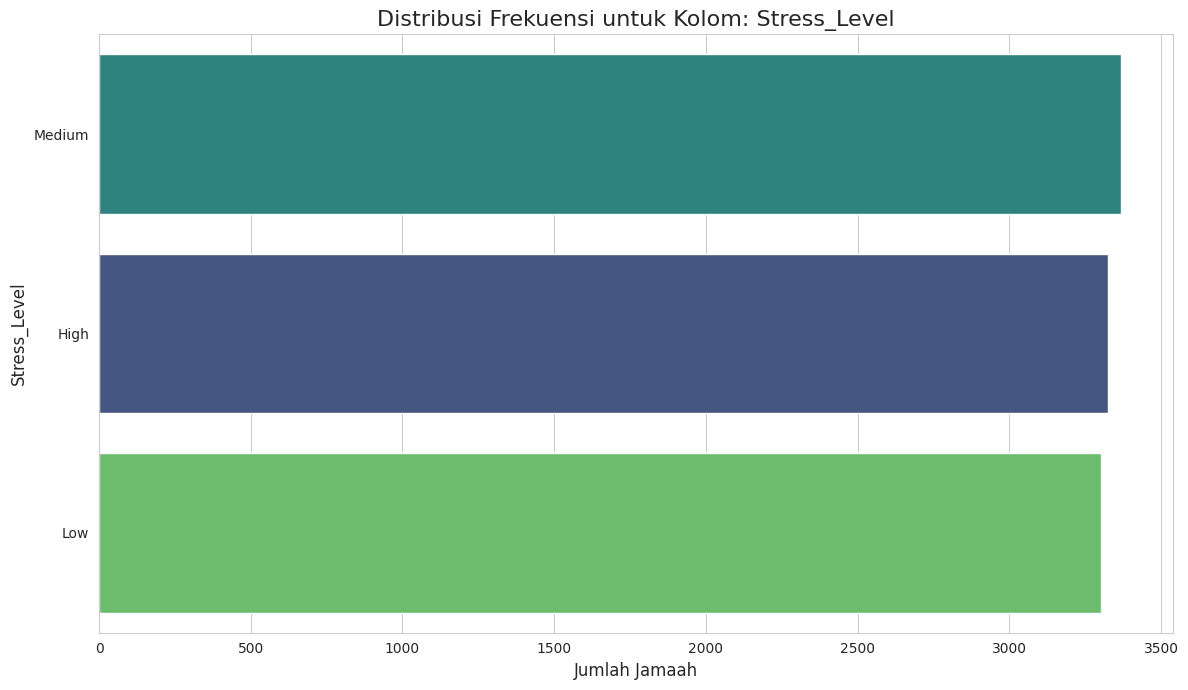

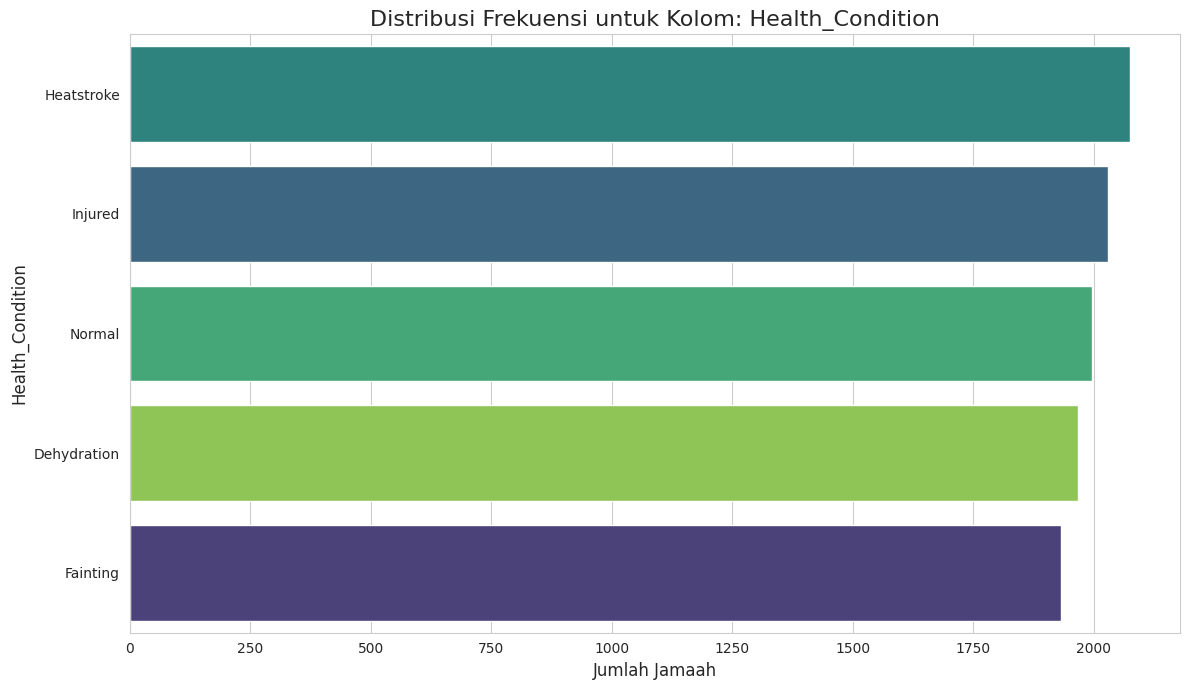

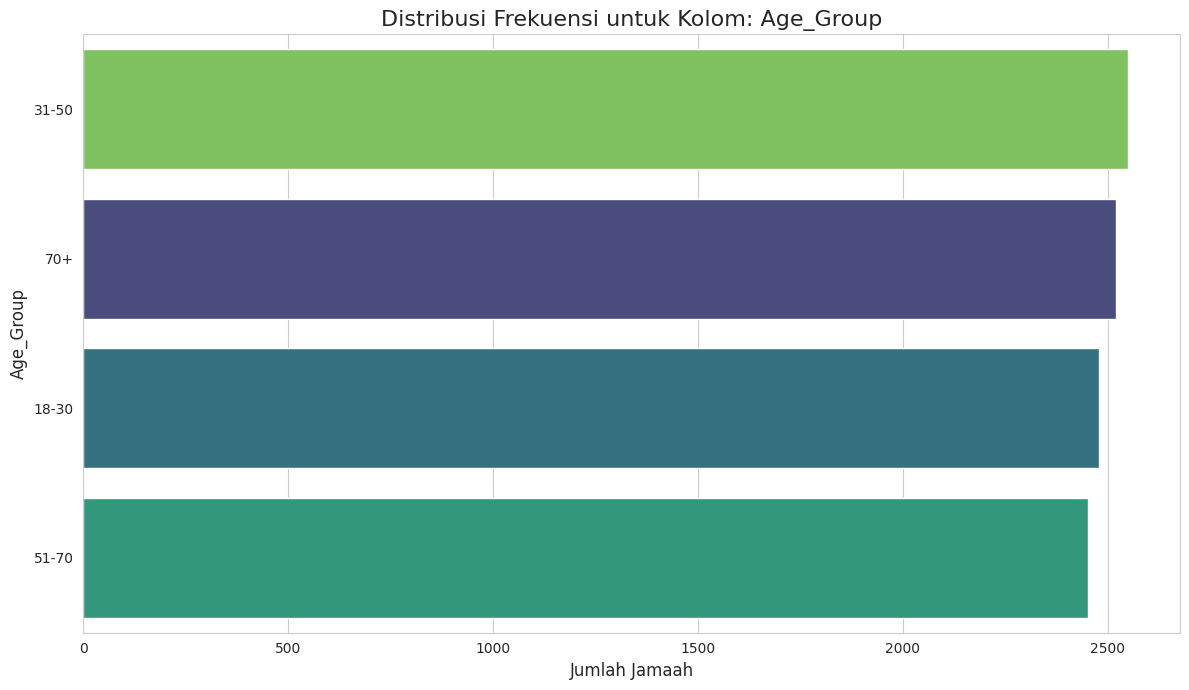

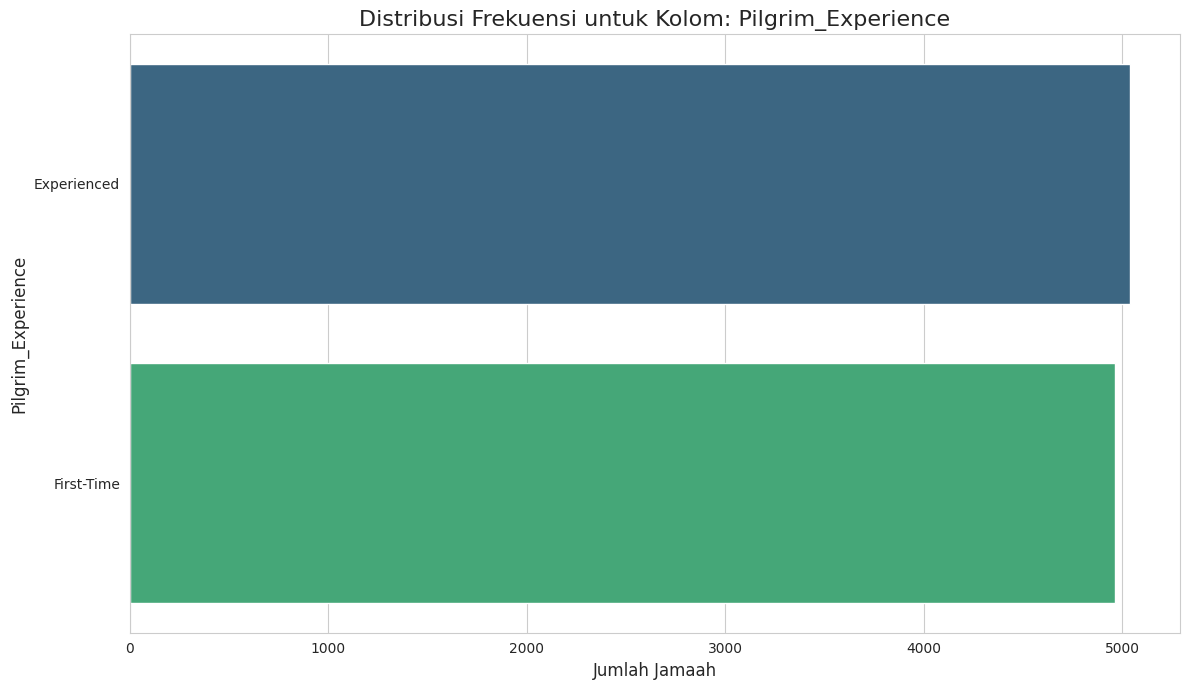

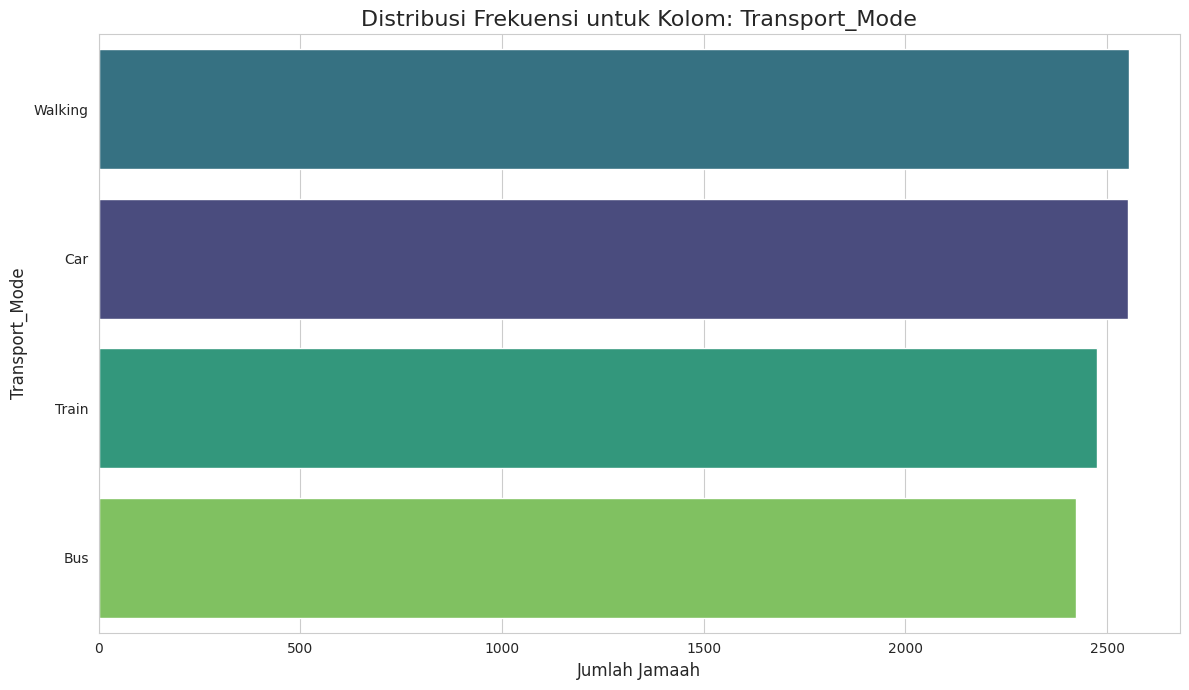

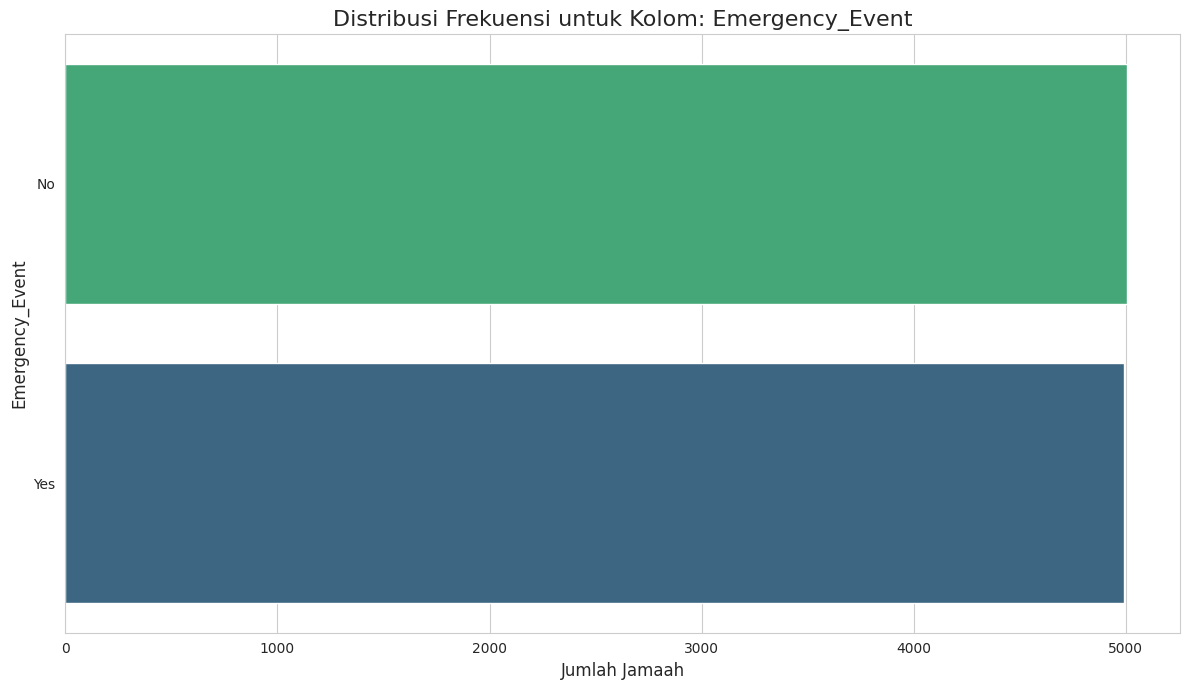

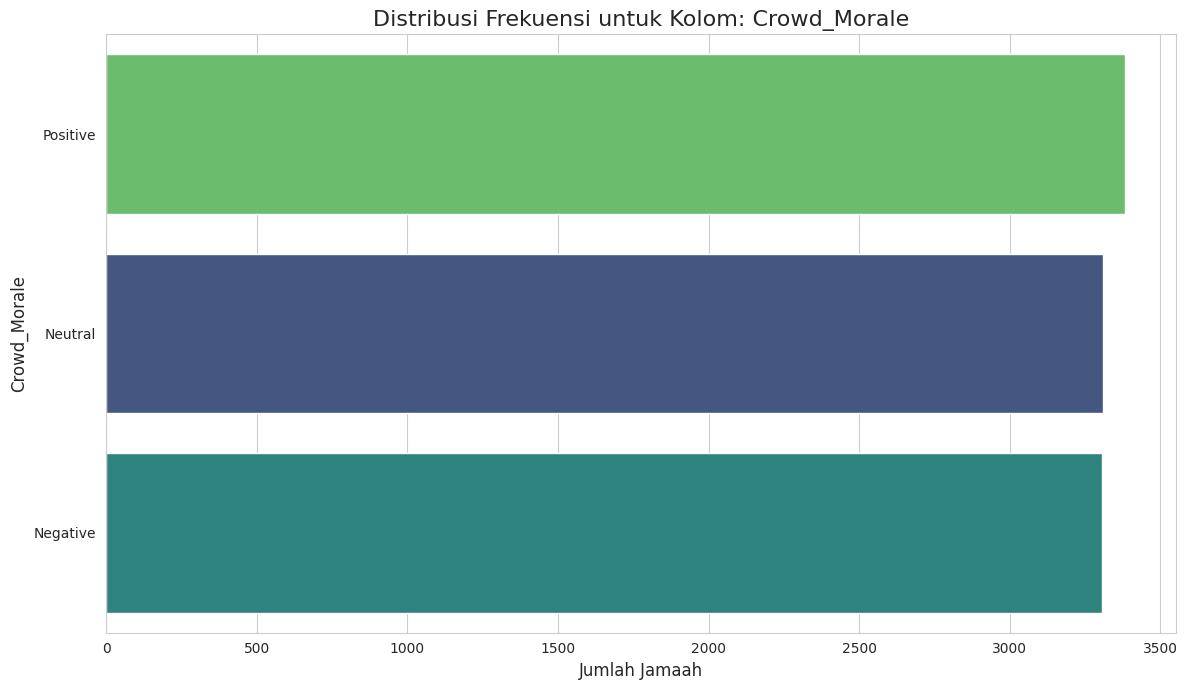

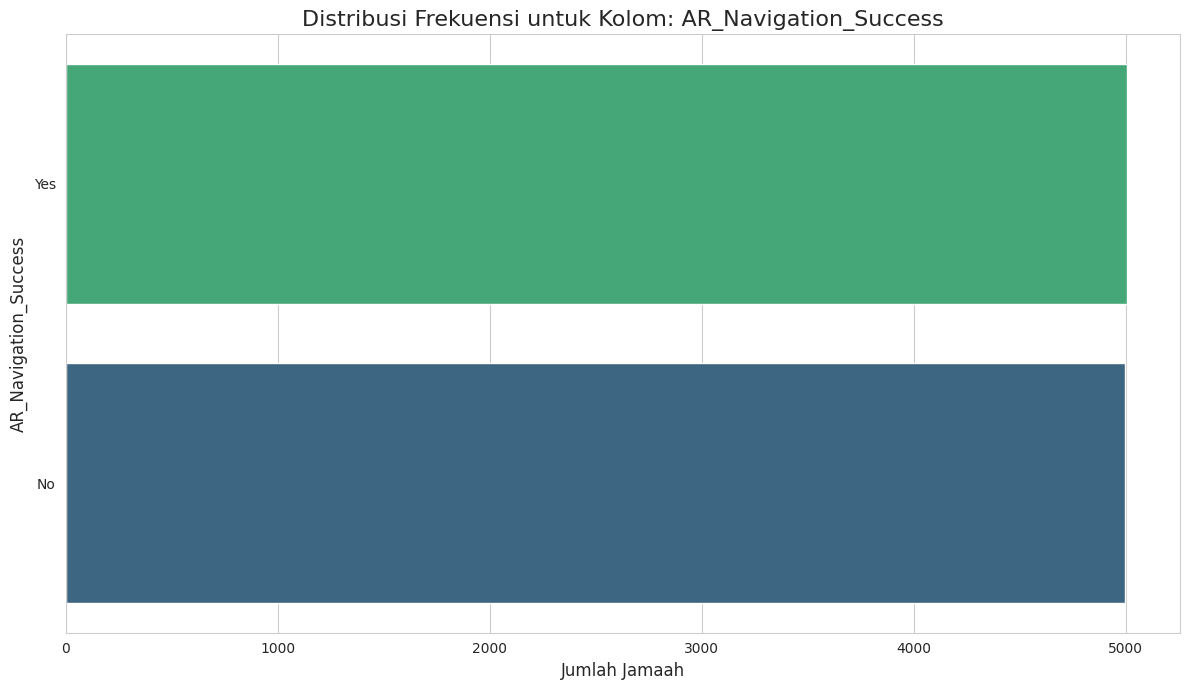

In [5]:
# Memilih beberapa kolom kategorikal yang paling relevan untuk dianalisis
categorical_cols = [
    'Crowd_Density', 'Activity_Type', 'Weather_Conditions',
    'Fatigue_Level', 'Stress_Level', 'Health_Condition',
    'Age_Group', 'Pilgrim_Experience', 'Transport_Mode',
    'Emergency_Event', 'Crowd_Morale', 'AR_Navigation_Success',
]

print("=== Distribusi Fitur Kategorikal ===\n")

# Membuat plot untuk setiap kolom kategorikal
for col in categorical_cols:
    plt.figure(figsize=(12, 7))
    # Menggunakan 'y' untuk orientasi horizontal agar label mudah dibaca
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis', hue=col, legend=False)
    plt.title(f'Distribusi Frekuensi untuk Kolom: {col}', fontsize=16)
    plt.xlabel('Jumlah Jamaah', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.tight_layout()
    plt.show()

Insight: (Berdasarkan plot yang dihasilkan oleh kode di atas)

Pengalaman Jamaah: Sebagian besar jamaah adalah First-Time (pertama kali), yang mungkin memiliki ekspektasi dan tingkat kepuasan yang berbeda dari jamaah Experienced.

Kondisi Psikologis: Tingkat Stress_Level dan Fatigue_Level paling banyak berada di level Medium dan High. Ini adalah faktor risiko yang jelas.

Kondisi Darurat: Proporsi Emergency_Event == 'Yes' cukup signifikan, menunjukkan bahwa insiden sering terjadi.

Aktivitas: Aktivitas jamaah terdistribusi cukup merata antara Tawaf, Sa’i, Prayer, Resting, dan Walking.

## *2.4 Analisis Bivariate (Korelasi Fitur)*

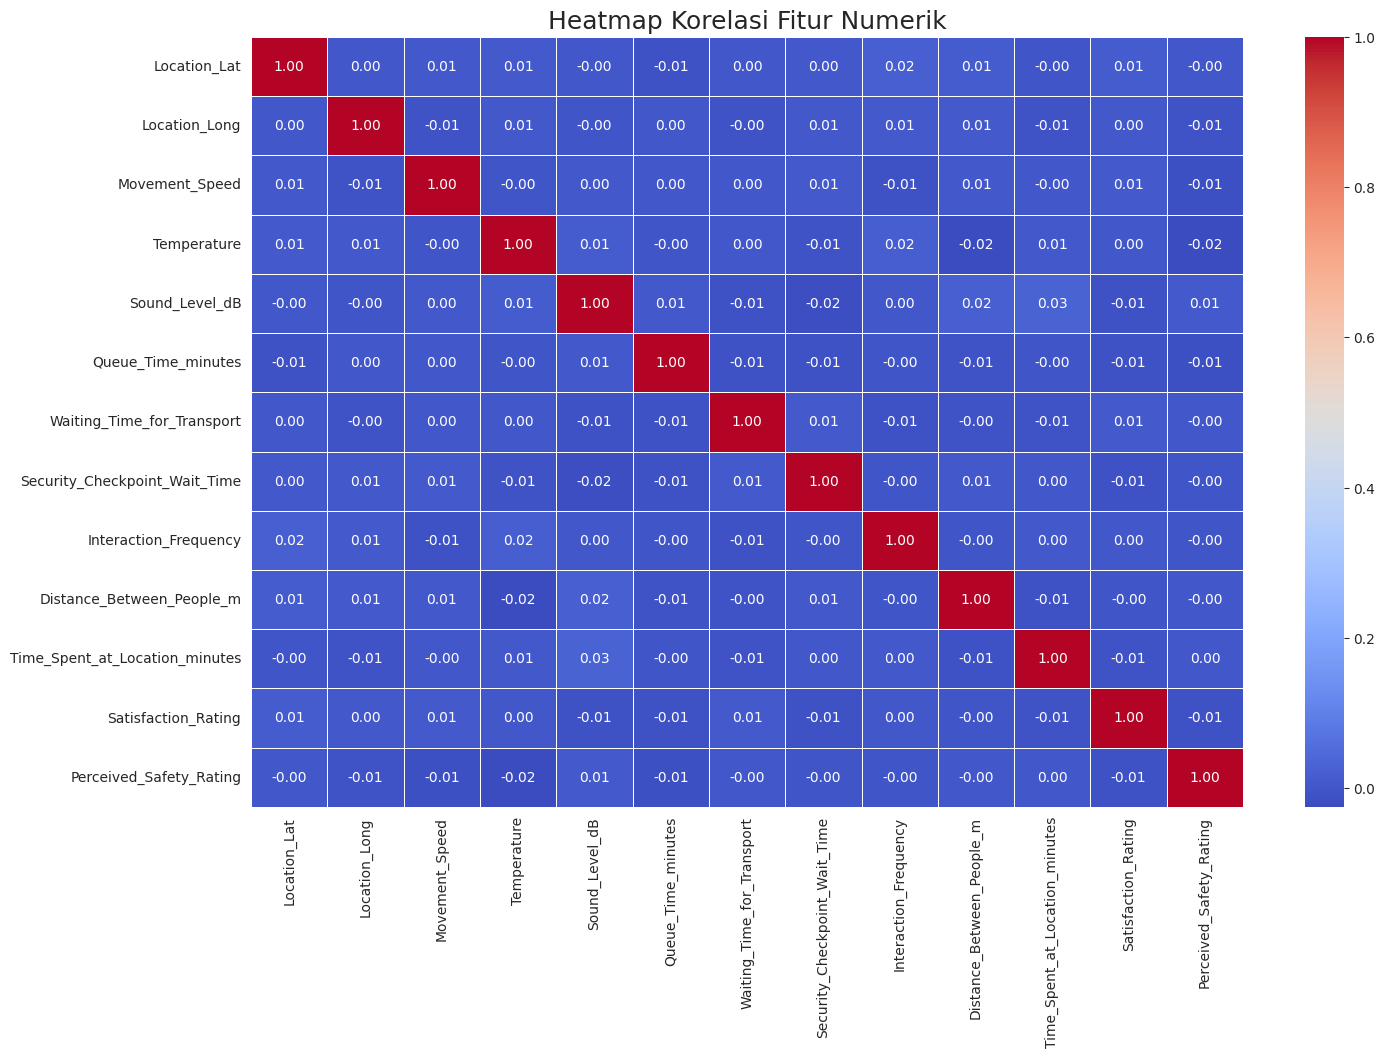

In [6]:
# Memilih hanya kolom numerik untuk heatmap korelasi
numerical_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(16, 10))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=18)
plt.show()

Korelasi dengan Kepuasan (Target: Satisfaction_Rating)


*   Hasil analisis heatmap menunjukkan bahwa tidak ada korelasi linear yang kuat antara Satisfaction_Rating dengan fitur numerik lainnya. Semua nilai korelasi sangat mendekati 0. Contohnya, korelasi positif terkuat hanya 0.01 (dengan Movement_Speed dan Distance_Between_People_m).

*   Korelasi negatif terkuat juga hanya -0.01 (dengan Queue_Time_minutes, Waiting_Time_for_Transport, Security_Checkpoint_Wait_Time, dan Time_Spent_at_Location_minutes).


Kesimpulan : Meskipun secara logika kita berpikir "semakin lama menunggu = semakin tidak puas", data ini menunjukkan bahwa hubungannya tidak linear. Nilai korelasi yang sangat kecil (0.01 atau -0.01) secara statistik bisa dianggap tidak ada korelasi.

Korelasi Antar Fitur (Multikolinearitas)

Tidak menemukan adanya korelasi kuat antar fitur independen (prediktor).
Sebagai contoh, korelasi antara Movement_Speed dan Distance_Between_People_m (yang secara logika harusnya berhubungan karena sama-sama mengukur kepadatan) ternyata nilainya sangat rendah, yaitu 0.01.

Kesimpulan  : Ini adalah kabar baik, karena artinya tidak ada masalah multikolinearitas yang signifikan di antara fitur-fitur numerik ini.

# **Persiapan Data & Rekayasa Fitur**

## **3.1 Pembersihan Data (Missing Values, Duplikat & Outlier)**

In [7]:
# 1. Mengecek nilai yang hilang (missing values)
missing_values = df.isnull().sum()
print("=== Pengecekan Nilai Hilang (Missing Values) per Kolom ===\n")
if missing_values.sum() == 0:
    print("Tidak ada nilai yang hilang di dalam dataset.")
else:
    print(missing_values[missing_values > 0])
print("\n" + "="*50 + "\n")


# 2. Mengecek data duplikat
duplicate_rows = df.duplicated().sum()
print("=== Pengecekan Data Duplikat ===\n")
if duplicate_rows == 0:
    print("Tidak ada baris data yang terduplikasi.")
else:
    print(f"Ditemukan {duplicate_rows} baris data yang terduplikasi.")

=== Pengecekan Nilai Hilang (Missing Values) per Kolom ===

Tidak ada nilai yang hilang di dalam dataset.


=== Pengecekan Data Duplikat ===

Tidak ada baris data yang terduplikasi.


Outlier


=== Pengecekan Outlier via Box Plot ===



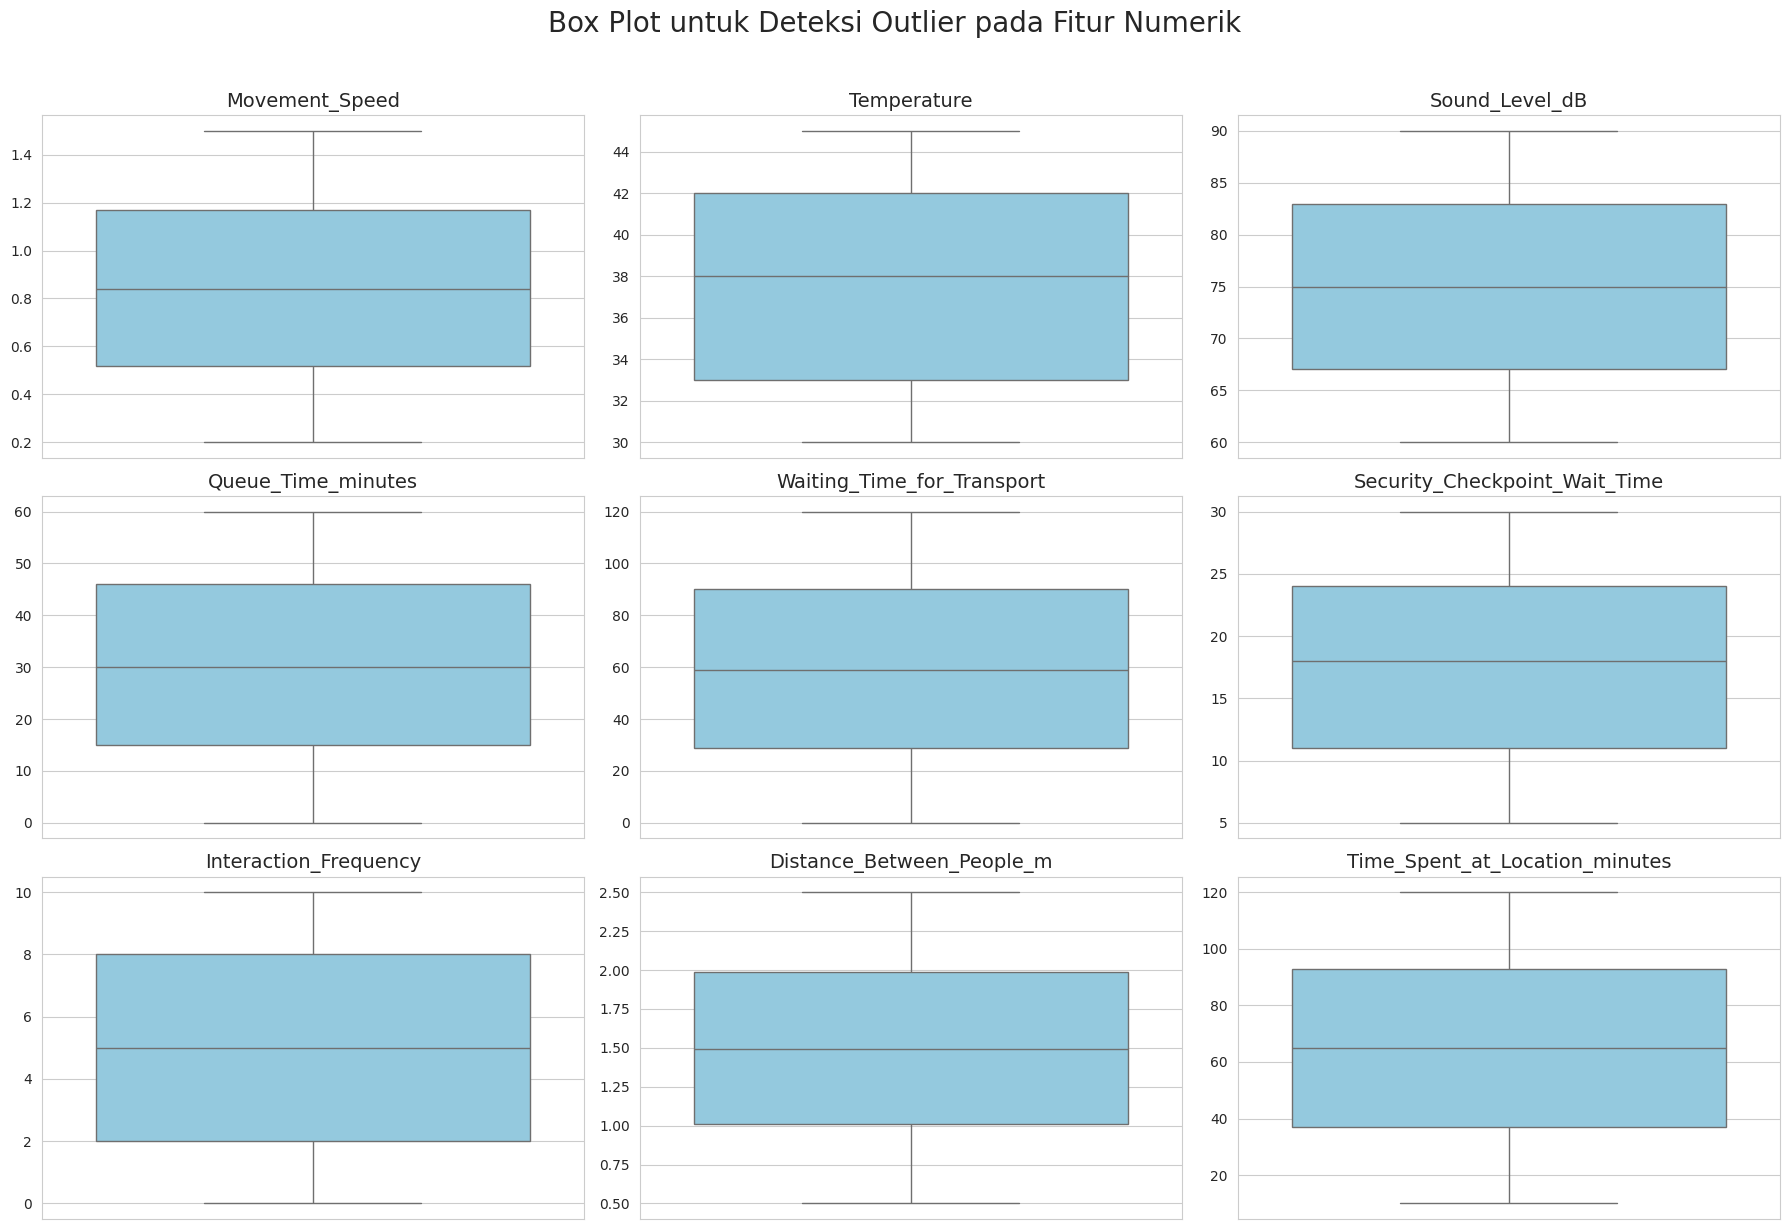

In [8]:
# Memilih kolom numerik yang relevan untuk dicek outliers-nya
numerical_cols_check = [
    'Movement_Speed', 'Temperature', 'Sound_Level_dB', 'Queue_Time_minutes',
    'Waiting_Time_for_Transport', 'Security_Checkpoint_Wait_Time',
    'Interaction_Frequency', 'Distance_Between_People_m', 'Time_Spent_at_Location_minutes'
]

# Membuat box plots untuk setiap kolom numerik
print("\n=== Pengecekan Outlier via Box Plot ===\n")
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols_check):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col, fontsize=14)
    plt.ylabel('')
plt.suptitle('Box Plot untuk Deteksi Outlier pada Fitur Numerik', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Insight:

Missing & Duplikat: Dataset ini 100% bersih dari nilai hilang dan duplikat.

Outlier: Berdasarkan boxplot, semua data berada dalam rentang yang wajar (misal, Queue_Time_minutes dari 0-60). Tidak ada outlier ekstrem atau data yang salah input. Oleh karena itu, kita tidak perlu menghapus outlier apapun.

25 OKT

Comment Mentor : **grouping kategori puas** 1-3 tidak puas, 4-5 puas

## **3.2 Rekayasa Fitur & Pemilihan Fitur**

Kita akan mengubah target Satisfaction_Rating (skala 1-5) menjadi biner: 1 (Puas) untuk rating 4-5, dan 0 (Tidak Puas) untuk rating 1-3.

In [9]:
# Membuat Variabel Target Biner
# Rating 4-5 -> 1 (Puas)
# Rating 1-3 -> 0 (Tidak Puas)
df['Satisfaction_Category'] = df['Satisfaction_Rating'].apply(lambda x: 1 if x >= 4 else 0)

# --- 2. Memilih Fitur (Feature Selection) ---
# Memilih fitur yang paling relevan berdasarkan EDA dan logika bisnis
features_to_keep = [
    'Crowd_Density', 'Movement_Speed', 'Activity_Type', 'Weather_Conditions',
    'Temperature', 'Fatigue_Level', 'Stress_Level', 'Queue_Time_minutes',
    'Health_Condition', 'Age_Group', 'Transport_Mode', 'Waiting_Time_for_Transport',
    'Security_Checkpoint_Wait_Time', 'Emergency_Event', 'Crowd_Morale',
    'Pilgrim_Experience', 'Interaction_Frequency', 'Distance_Between_People_m',
    'Time_Spent_at_Location_minutes', 'AR_Navigation_Success'
]

target = 'Satisfaction_Category'

Pemilihan Fitur: Kita akan memilih fitur-fitur yang relevan untuk model (features_to_keep) dan membuang yang tidak perlu (seperti ID, lokasi, atau target asli).

In [10]:
# Membuat DataFrame baru yang hanya berisi fitur terpilih dan target
df_model = df[features_to_keep + [target]]

print("=== DataFrame Siap untuk Pemodelan ===\n")
print(f"Jumlah fitur yang akan digunakan: {len(df_model.columns) - 1}")
print("Target baru kita (0 = Tidak Puas, 1 = Puas):")
print(df_model['Satisfaction_Category'].value_counts(normalize=True))
print("\nInfo DataFrame Baru:")
df_model.info()

=== DataFrame Siap untuk Pemodelan ===

Jumlah fitur yang akan digunakan: 20
Target baru kita (0 = Tidak Puas, 1 = Puas):
Satisfaction_Category
0    0.5943
1    0.4057
Name: proportion, dtype: float64

Info DataFrame Baru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Crowd_Density                   10000 non-null  object 
 1   Movement_Speed                  10000 non-null  float64
 2   Activity_Type                   10000 non-null  object 
 3   Weather_Conditions              10000 non-null  object 
 4   Temperature                     10000 non-null  int64  
 5   Fatigue_Level                   10000 non-null  object 
 6   Stress_Level                    10000 non-null  object 
 7   Queue_Time_minutes              10000 non-null  int64  
 8   Health_Condition                10000 non-null  object

Insight:

Kita telah berhasil mengubah masalah ini menjadi Klasifikasi Biner.

Target kita sekarang tidak seimbang (imbalanced). Terdapat 59.4% data "Tidak Puas" (kelas 0) dan 40.6% data "Puas" (kelas 1). Ini penting untuk diingat saat evaluasi model.

DataFrame baru kita, df_model, sekarang memiliki 20 fitur prediktor dan 1 kolom target.

## 3.3 Transformasi Data (Encoding & Scaling)

In [11]:
# --- 1. Memisahkan Fitur (X) dan Target (y) ---
X = df_model.drop('Satisfaction_Category', axis=1)
y = df_model['Satisfaction_Category']

In [12]:
# --- 2. Melakukan One-Hot Encoding pada Fitur Kategorikal ---
# 'get_dummies' secara otomatis akan mengubah semua kolom 'object' menjadi kolom numerik
# drop_first=True untuk menghindari multicollinearity (dummy variable trap)
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

In [13]:
# --- 3. Melakukan Scaling pada Fitur Numerik ---
# Mengidentifikasi kolom mana yang numerik ASLI (sebelum encoding) untuk di-scale
numeric_cols_to_scale = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

# Melakukan scaling hanya pada kolom-kolom numerik asli
X_encoded[numeric_cols_to_scale] = scaler.fit_transform(X_encoded[numeric_cols_to_scale])

print("=== Proses Transformasi Selesai ===\n")
print(f"Bentuk data fitur (X) setelah encoding dan scaling: {X_encoded.shape}")
print(f"Artinya, kita sekarang punya {X_encoded.shape[0]} baris data dan {X_encoded.shape[1]} fitur (setelah one-hot).")
print(" 5 baris pertama dari data yang sudah ditransformasi:")
print(X_encoded.head())

=== Proses Transformasi Selesai ===

Bentuk data fitur (X) setelah encoding dan scaling: (10000, 35)
Artinya, kita sekarang punya 10000 baris data dan 35 fitur (setelah one-hot).
 5 baris pertama dari data yang sudah ditransformasi:
   Movement_Speed  Temperature  Queue_Time_minutes  \
0        0.144268     1.406483           -0.806335   
1       -0.782106     0.322004            0.720761   
2        0.250140    -1.196268           -0.636658   
3       -0.782106     0.755796           -0.127626   
4       -1.284995     1.406483           -0.862895   

   Waiting_Time_for_Transport  Security_Checkpoint_Wait_Time  \
0                    0.522593                      -1.537748   
1                    1.491491                       0.720052   
2                    0.380107                       0.720052   
3                    0.636581                       0.720052   
4                   -1.187229                      -0.076818   

   Interaction_Frequency  Distance_Between_People_m  \
0 

Data sekarang sepenuhnya numerik dan siap untuk modelling.

Fitur kategorikal telah diubah. Misalnya, Activity_Type yang memiliki 5 kategori (Prayer, Resting, Sa'i, Tawaf, Walking) diubah menjadi 4 kolom biner (misal: Activity_Type_Resting).

Total fitur berkembang dari 20 menjadi 35 kolom karena proses one-hot encoding.

## 3.4 Pemisahan Data (Train-Test Split)

Memisahkan data kita menjadi set data latih (train) dan data uji (test). Kita akan menggunakan 80% data untuk melatih model dan 20% untuk mengujinya.

In [14]:
# Memisahkan data menjadi 80% data latih dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("=== Pemisahan Data Selesai ===\n")
print(f"Bentuk X_train (fitur latih): {X_train.shape}")
print(f"Bentuk X_test (fitur uji): {X_test.shape}")
print(f"Bentuk y_train (target latih): {y_train.shape}")
print(f"Bentuk y_test (target uji): {y_test.shape}\n")

print("Proporsi target di data latih (y_train):")
print(y_train.value_counts(normalize=True))
print("\nProporsi target di data uji (y_test):")
print(y_test.value_counts(normalize=True))

=== Pemisahan Data Selesai ===

Bentuk X_train (fitur latih): (8000, 35)
Bentuk X_test (fitur uji): (2000, 35)
Bentuk y_train (target latih): (8000,)
Bentuk y_test (target uji): (2000,)

Proporsi target di data latih (y_train):
Satisfaction_Category
0    0.59425
1    0.40575
Name: proportion, dtype: float64

Proporsi target di data uji (y_test):
Satisfaction_Category
0    0.5945
1    0.4055
Name: proportion, dtype: float64


Insight: Pemisahan berhasil. Kita memiliki 8000 baris data latih dan 2000 baris data uji. Proporsi kelas 0 dan 1 hampir identik di kedua set, yang menunjukkan stratification berhasil.

# Pemodelan & Evaluasi

Melatih beberapa model klasifikasi pada data latih (X_train, y_train) dan mengevaluasinya pada data uji (X_test, y_test).

## 4.1 Model 1: K-Nearest Neighbors (Baseline)
Kita akan melihat metrik utamanya, terutama f1-score untuk kelas 1 (Puas).

=== Hasil Evaluasi Model K-Nearest Neighbors (KNN) ===

                precision    recall  f1-score   support

Tidak Puas (0)       0.59      0.66      0.62      1189
      Puas (1)       0.39      0.32      0.36       811

      accuracy                           0.52      2000
     macro avg       0.49      0.49      0.49      2000
  weighted avg       0.51      0.52      0.51      2000


=== Confusion Matrix untuk KNN ===



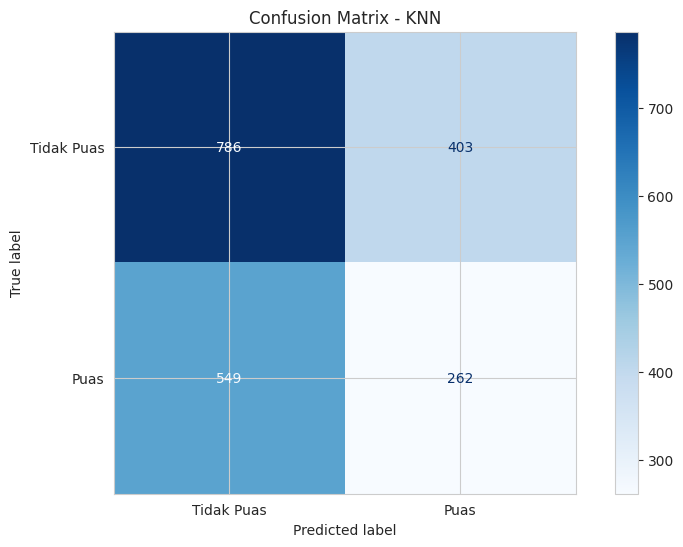

In [15]:
# 1. Membuat dan melatih model KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 2. Membuat prediksi pada data uji
y_pred_knn = knn_model.predict(X_test)

# 3. Mengevaluasi performa model
print("=== Hasil Evaluasi Model K-Nearest Neighbors (KNN) ===\n")
print(classification_report(y_test, y_pred_knn, target_names=['Tidak Puas (0)', 'Puas (1)']))

# 4. Menampilkan Confusion Matrix
print("\n=== Confusion Matrix untuk KNN ===\n")
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, cmap='Blues', display_labels=['Tidak Puas', 'Puas'])
plt.title('Confusion Matrix - KNN')
plt.show()

Insight:

Akurasi: Akurasi keseluruhan hanya 52%, sedikit lebih baik dari tebakan acak (50%).

Performa Kelas 1 (Puas): Model ini sangat buruk dalam memprediksi jamaah yang "Puas". Recall untuk kelas 1 hanya 0.32 (artinya model hanya berhasil menemukan 32% dari semua jamaah yang puas) dan f1-score (rata-rata precision & recall) hanya 0.36.

## 4.2 Model 2: XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Hasil Evaluasi Model XGBoost Classifier ===

                precision    recall  f1-score   support

Tidak Puas (0)       0.60      0.72      0.65      1189
      Puas (1)       0.41      0.28      0.33       811

      accuracy                           0.54      2000
     macro avg       0.50      0.50      0.49      2000
  weighted avg       0.52      0.54      0.52      2000


=== Confusion Matrix untuk XGBoost ===



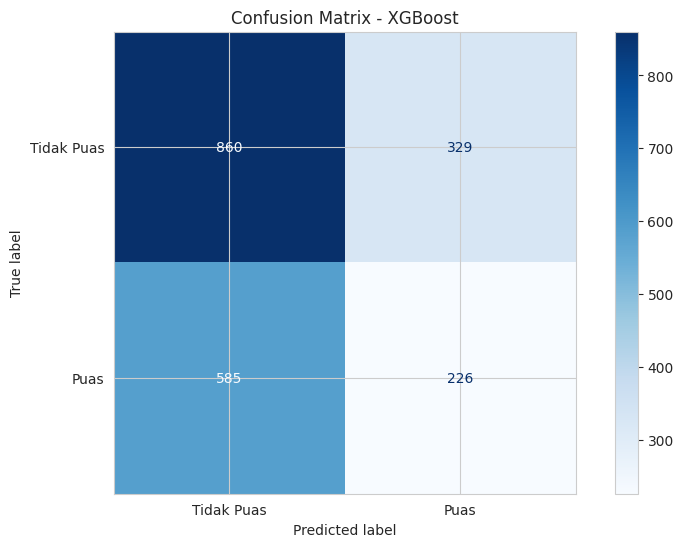

In [16]:
# 1. Membuat dan melatih model XGBoost
# eval_metric='logloss' umum digunakan untuk klasifikasi biner
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 2. Membuat prediksi pada data uji
y_pred_xgb = xgb_model.predict(X_test)

# 3. Mengevaluasi performa model
print("=== Hasil Evaluasi Model XGBoost Classifier ===\n")
print(classification_report(y_test, y_pred_xgb, target_names=['Tidak Puas (0)', 'Puas (1)']))

# 4. Menampilkan Confusion Matrix
print("\n=== Confusion Matrix untuk XGBoost ===\n")
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, cmap='Blues', display_labels=['Tidak Puas', 'Puas'])
plt.title('Confusion Matrix - XGBoost')
plt.show()

Insight:

Akurasi: Akurasi naik sedikit menjadi 54%.

Performa Kelas 1 (Puas): Anehnya, performa untuk kelas 1 (Puas) justru lebih buruk dari KNN. Recall turun menjadi 0.28 dan f1-score menjadi 0.33.

Masalah: Model ini tampaknya sangat bias terhadap kelas mayoritas (0 = Tidak Puas). Confusion Matrix menunjukkan model ini memprediksi 861 jamaah sebagai "Tidak Puas" padahal sebenarnya mereka "Puas". Ini karena datanya imbalanced.

Nilai scale_pos_weight yang akan digunakan: 1.46




/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Hasil Evaluasi Model XGBoost (Setelah Tuning) ===

                precision    recall  f1-score   support

Tidak Puas (0)       0.59      0.62      0.61      1189
      Puas (1)       0.40      0.37      0.39       811

      accuracy                           0.52      2000
     macro avg       0.50      0.50      0.50      2000
  weighted avg       0.52      0.52      0.52      2000


=== Confusion Matrix untuk XGBoost (Setelah Tuning) ===



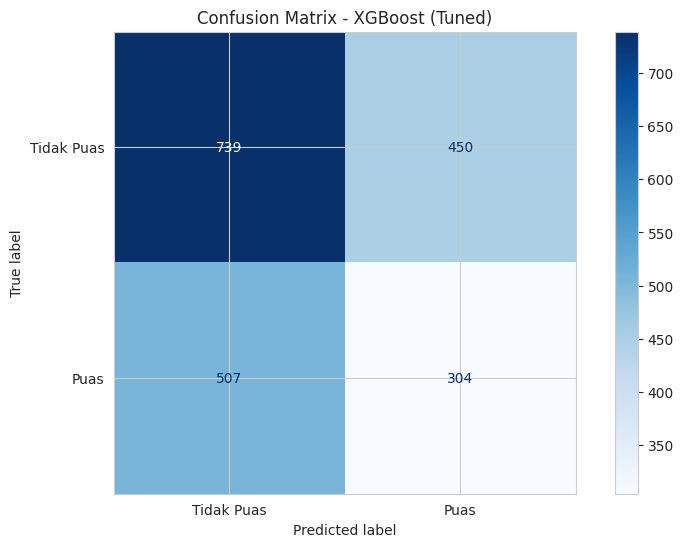

In [17]:
# --- 1. Menghitung scale_pos_weight untuk mengatasi ketidakseimbangan kelas ---
# Rumus = jumlah kelas mayoritas (0) / jumlah kelas minoritas (1)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Nilai scale_pos_weight yang akan digunakan: {scale_pos_weight:.2f}\n")
print("="*50 + "\n")


# --- 2. Membuat dan melatih model XGBoost yang sudah di-tuning ---
xgb_tuned_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Ini adalah parameter baru kita!
    random_state=42
)
xgb_tuned_model.fit(X_train, y_train)


# --- 3. Membuat prediksi pada data uji ---
y_pred_xgb_tuned = xgb_tuned_model.predict(X_test)


# --- 4. Mengevaluasi performa model yang sudah di-tuning ---
print("=== Hasil Evaluasi Model XGBoost (Setelah Tuning) ===\n")
print(classification_report(y_test, y_pred_xgb_tuned, target_names=['Tidak Puas (0)', 'Puas (1)']))


# --- 5. Menampilkan Confusion Matrix ---
print("\n=== Confusion Matrix untuk XGBoost (Setelah Tuning) ===\n")
ConfusionMatrixDisplay.from_estimator(xgb_tuned_model, X_test, y_test, cmap='Blues', display_labels=['Tidak Puas', 'Puas'])
plt.title('Confusion Matrix - XGBoost (Tuned)')
plt.show()

Insight:

Perbaikan Signifikan: Meskipun akurasi keseluruhan turun sedikit ke 52%, lihatlah performa kelas 1 (Puas)!

Recall untuk "Puas" naik dari 0.28 (model awal) menjadi 0.37.

F1-Score untuk "Puas" naik dari 0.33 menjadi 0.39.

Confusion Matrix mengkonfirmasi ini: model tuned ini sekarang salah memprediksi "Puas" sebagai "Tidak Puas" sebanyak 509 kali (turun dari 861!). Ini adalah model yang jauh lebih seimbang dan berguna untuk tujuan bisnis kita, yaitu mengidentifikasi jamaah yang puas

# **Kesimpulan & Rekomendasi**

## 5.1 Interpretasi Hasil Model

Model terbaik kita adalah xgb_tuned_model.

=== 15 Fitur Terpenting Menurut Model XGBoost ===

                           feature  importance
30             Emergency_Event_Yes    0.034140
23         Health_Condition_Normal    0.032546
28            Transport_Mode_Train    0.032075
13           Activity_Type_Walking    0.031595
6        Distance_Between_People_m    0.030784
26                   Age_Group_70+    0.030752
3       Waiting_Time_for_Transport    0.030559
11              Activity_Type_Sa’i    0.030538
32           Crowd_Morale_Positive    0.029951
14       Weather_Conditions_Cloudy    0.029840
7   Time_Spent_at_Location_minutes    0.029685
0                   Movement_Speed    0.029562
21     Health_Condition_Heatstroke    0.029246
19             Stress_Level_Medium    0.029081
4    Security_Checkpoint_Wait_Time    0.029072


=== Visualisasi Feature Importance ===



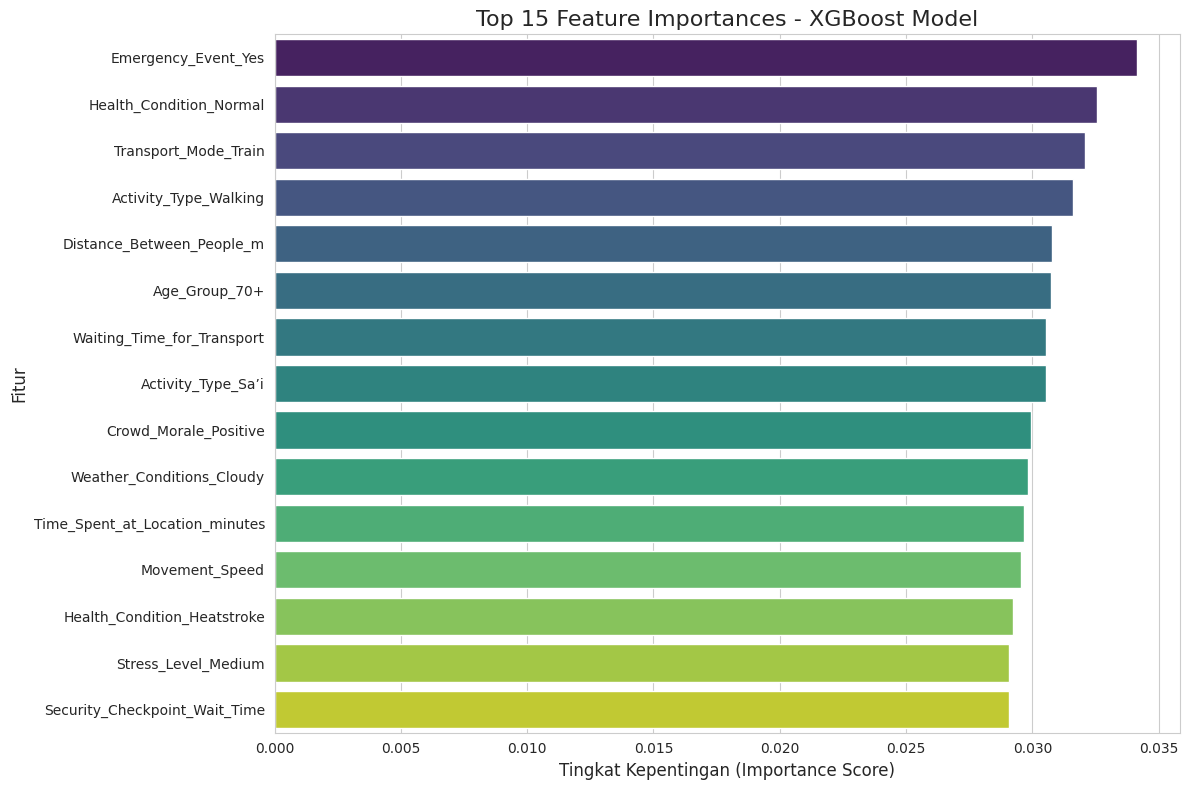

In [18]:
# 1. Mendapatkan nilai pentingnya setiap fitur dari model
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': xgb_tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Menampilkan 15 fitur teratas
top_15_features = feature_importances.head(15)
print("=== 15 Fitur Terpenting Menurut Model XGBoost ===\n")
print(top_15_features)
print("\n" + "="*50 + "\n")


# 3. Membuat visualisasi
print("=== Visualisasi Feature Importance ===\n")
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_15_features, palette='viridis', hue='feature', legend=False)
plt.title('Top 15 Feature Importances - XGBoost Model', fontsize=16)
plt.xlabel('Tingkat Kepentingan (Importance Score)', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.show()

Insight: Fitur-fitur terpenting yang ditemukan model adalah:

Emergency_Event_Yes: Apakah terjadi insiden darurat.

Health_Condition_Normal: Apakah jamaah dalam kondisi sehat.

Transport_Mode_Train: Apakah menggunakan kereta sebagai transportasi.

Activity_Type_Walking: Apakah aktivitasnya sedang berjalan kaki.

Distance_Between_People_m: Jarak antar jamaah (indikator kepadatan).

Age_Group_70+: Apakah jamaah berusia lansia.

Ini memberikan kita insight yang sangat jelas tentang apa yang harus diprioritaskan.

## 5.2 Rekomendasi Bisnis

Berdasarkan temuan dari feature importance dan EDA, berikut adalah beberapa rekomendasi yang dapat ditindaklanjuti untuk penyelenggara ibadah haji guna meningkatkan kepuasan.

Rekomendasi:


1.   Prioritas Utama: Manajemen Insiden & Kesehatan.

Fitur Emergency_Event_Yes dan Health_Condition_Normal adalah prediktor teratas. Ini menunjukkan bahwa pencegahan dan kecepatan respons terhadap insiden darurat dan masalah kesehatan adalah faktor paling krusial yang menentukan kepuasan jamaah.

Rekomendasi: Tingkatkan jumlah pos kesehatan, perpendek waktu respons tim medis, dan pastikan alur evakuasi darurat jelas dan cepat.

2.   Fokus pada Titik Rawan: Transportasi dan Area Berjalan Kaki.

Fitur Transport_Mode_Train dan Activity_Type_Walking memiliki importance tinggi. Ini kemungkinan besar adalah titik-titik di mana terjadi waktu tunggu (Queue_Time) dan kepadatan (Crowd_Density) yang tinggi.

Rekomendasi: Analisis lebih lanjut alur antrian di stasiun kereta dan jalur berjalan kaki (misal: area Sa'i atau Tawaf). Tambahkan petugas atau ubah alur untuk mengurangi kemacetan di area-area ini.

3.   Lindungi Kelompok Rentan: Lansia (70+).

Fitur Age_Group_70+ muncul sebagai faktor penting. Kelompok ini paling rentan terhadap Fatigue_Level dan Stress_Level yang tinggi (seperti yang terlihat di EDA).

Rekomendasi: Sediakan jalur khusus, area istirahat, dan bantuan prioritas untuk jamaah lansia, terutama di titik-titik rawan yang teridentifikasi di poin #2.


4.   Manajemen Kepadatan Aktif.

Fitur Distance_Between_People_m (jarak antar orang) secara langsung memengaruhi kepuasan.

Rekomendasi: Gunakan data ini (mungkin dari sensor atau CCTV) secara real-time untuk mengalihkan jamaah dari area yang terlalu padat (jarak < 1m) ke area yang lebih lengang.

## 5.3 Keterbatasan & Tantangan

Keterbatasan Performa Model

Performa model terbaik (XGBoost Tuned) masih tergolong rendah, dengan F1-Score untuk kelas "Puas" hanya 0.39.

Ini menunjukkan bahwa fitur-fitur yang ada saat ini belum cukup kuat untuk memprediksi kepuasan jamaah secara akurat.

Tantangan: Sifat Dataset yang Sintetis (Artifisial)

Kesulitan model dalam menemukan pola yang kuat kemungkinan besar disebabkan oleh sifat dataset yang sangat bersih atau sintetis.

Bukti Observasi:

Distribusi Target Sempurna: Distribusi skor Satisfaction_Rating (1-5) sangat seimbang (~2000 sampel per kelas), yang sangat jarang terjadi pada data survei di dunia nyata.

Tidak Ada Cacat Data: Dataset ini 100% bersih dari missing values dan data duplikat.

Tidak Ada Outlier: Semua fitur numerik (seperti waktu antri atau suhu) berada dalam rentang yang wajar tanpa ada data pencilan (pencilan) yang ekstrem.